# Grading Diabetic Retinopathy by Classification with MobileNet

In [1]:
from datetime import datetime as dt

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Activation
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.models import Model
from keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import os
from os import listdir,mkdir
import shutil
import random
import matplotlib.pyplot as plt
%matplotlib inline

2022-11-19 16:09:30.047413: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-19 16:09:30.154458: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-11-19 16:09:30.179285: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-19 16:09:30.655155: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available:  1


2022-11-19 16:09:31.577888: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-19 16:09:31.583646: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-19 16:09:31.583777: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


**Model parameters**

In [3]:
today = dt.today().strftime("%Y-%m-%d_%H-%M-%S")
application = {
    'grading_dr': {
        'train_path' : './Dataset_grad/training/',
        'test_path' : './Dataset_grad/testing/',
        'validation_path' : './Dataset_grad/validation/',
        'model_name': f'grading_dr_{today}.h5',
        'cm-title': 'Grading DR Confusion Matrix',
        'cm-path': f'confusion_grading_dr_{today}.jpg',
        'cm_plotlabels' : ['healthy','level-1','level-2','level-3'],
        'num_classes': 4
    },
    'referability': {
        'train_path' : './Dataset_ref/training/',
        'test_path' : './Dataset_ref/testing/',
        'validation_path' : './Dataset_ref/validation/',
        'model_name': f'referability_{today}.h5',
        'cm-title': 'Referability Confusion Matrix',
        'cm-path': f'referability_dr_{today}.jpg',
        'cm_plotlabels' : ['non-referable', 'referable'],
        'num_classes': 2
    }
}

batch_size = 10
h_w = 224

MODELS_PATH = './models/'
if 'models' not in listdir('./'):
    mkdir(MODELS_PATH)

CM_PATH = './confusion_matrices/'
if 'confusion_matrices' not in listdir('./'):
    mkdir(CM_PATH)


In [4]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          path='confusion_matrix.jpg',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig((CM_PATH + path))
    plt.show()

In [5]:
def prepare_training(app: dict):
    train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input).flow_from_directory(
        directory=app['train_path'], target_size=(h_w,h_w), batch_size=batch_size)
    validation_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input).flow_from_directory(
        directory=app['test_path'], target_size=(h_w,h_w), batch_size=batch_size)
    test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input).flow_from_directory(
        directory=app['validation_path'], target_size=(h_w,h_w), batch_size=batch_size)

    model = tf.keras.applications.mobilenet_v2.MobileNetV2(
        input_shape=None,
        alpha=1.0,
        include_top=True,
        weights=None,
        input_tensor=None,
        pooling=None,
        classes=app['num_classes'],
        classifier_activation='softmax')
    model.summary()

    model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

    title = app['cm-title']
    pathname = app['cm-path']
    plot_labels = app['cm_plotlabels']
    
    return train_batches, validation_batches, test_batches, model, app['model_name'], title, pathname, plot_labels

In [6]:
train_batches, validation_batches, test_batches, model, model_name, cm_name, cm_pathname, plot_labels = prepare_training(application['grading_dr'])

Found 1267 images belonging to 4 classes.
Found 100 images belonging to 4 classes.
Found 100 images belonging to 4 classes.


2022-11-19 16:09:31.722052: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-19 16:09:31.722483: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-19 16:09:31.722662: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-19 16:09:31.722899: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so ret

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [7]:

model.fit(x=train_batches,
            steps_per_epoch=len(train_batches),
            validation_data=validation_batches,
            validation_steps=len(validation_batches),
            callbacks=tf.keras.callbacks.ModelCheckpoint(filepath=MODELS_PATH + model_name,monitor='val_accuracy', mode='max', save_best_only= False,verbose=2),
            epochs=70,
            verbose=2
)

Epoch 1/70


2022-11-19 16:09:36.932692: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101
2022-11-19 16:09:38.224063: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.



Epoch 1: saving model to ./models/grading_dr_2022-11-19_16-09-31.h5
127/127 - 18s - loss: 1.3096 - accuracy: 0.3725 - val_loss: 1.3866 - val_accuracy: 0.2500 - 18s/epoch - 143ms/step
Epoch 2/70

Epoch 2: saving model to ./models/grading_dr_2022-11-19_16-09-31.h5
127/127 - 13s - loss: 0.9695 - accuracy: 0.5998 - val_loss: 1.3899 - val_accuracy: 0.2500 - 13s/epoch - 105ms/step
Epoch 3/70

Epoch 3: saving model to ./models/grading_dr_2022-11-19_16-09-31.h5
127/127 - 13s - loss: 0.7133 - accuracy: 0.7285 - val_loss: 1.4010 - val_accuracy: 0.2500 - 13s/epoch - 105ms/step
Epoch 4/70

Epoch 4: saving model to ./models/grading_dr_2022-11-19_16-09-31.h5
127/127 - 13s - loss: 0.5472 - accuracy: 0.7869 - val_loss: 1.4312 - val_accuracy: 0.2500 - 13s/epoch - 103ms/step
Epoch 5/70

Epoch 5: saving model to ./models/grading_dr_2022-11-19_16-09-31.h5
127/127 - 13s - loss: 0.4726 - accuracy: 0.8106 - val_loss: 1.4699 - val_accuracy: 0.2500 - 13s/epoch - 103ms/step
Epoch 6/70

Epoch 6: saving model to

{'0': 0, '1': 1, '2': 2, '3': 3}

10/10 - 1s - 905ms/epoch - 90ms/step
Confusion matrix, without normalization
[[20  0  0  5]
 [15  0  0 10]
 [17  1  0  7]
 [12  0  0 13]]


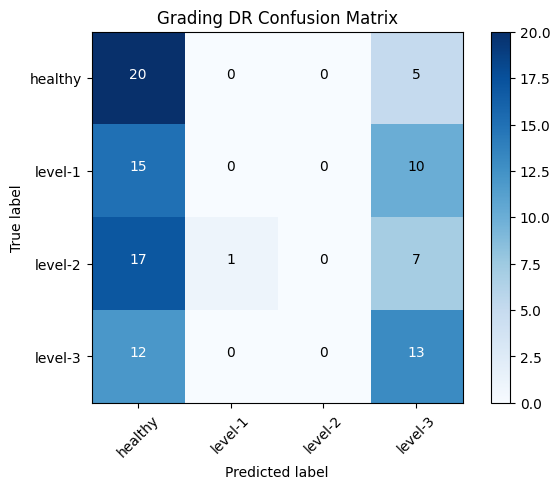

In [11]:
test_labels = test_batches.classes
display(test_batches.class_indices)

predictions = model.predict(x=test_batches, steps=len(test_batches), verbose=2)
cm = confusion_matrix(y_true=test_labels, y_pred=predictions.argmax(axis=1))

plot_confusion_matrix(cm=cm, classes=plot_labels, title=cm_name, path=cm_pathname)